In [1]:
!pip install elasticdeform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 4.7 MB/s eta 0:00:00


In [2]:
import os
import cv2
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
from torch import nn
import csv

# from torchvision.transforms.v2 import GaussianNoise
# from torchvision import transforms

from torchvision.ops import sigmoid_focal_loss

# from medpy.io import load
import pickle

from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import v2
import torchvision.transforms.v2.functional as Fv2

import elasticdeform
from torch.utils.data import ConcatDataset

import sys
sys.path.insert(1, '/kaggle/input/extra-code/extras')
from extra import *


train_log_path = 'new_train_log'
os.makedirs(train_log_path,exist_ok=True)

### Dataset

In [3]:
ROOT_PATH = "/kaggle/input/brats2013-img-data-normalizedind-256-bin/brats2013_img_data_normalizedIND_256_bin"
# ROOT_PATH = "/kaggle/input/brats2013-img-data-normalizedind-256-bin-all/brats2013_img_data_normalizedIND_256_bin_all"

class Brats2013(Dataset):
    def __init__(self, split_name, transform=None, root_path=ROOT_PATH):
        self.root_path = root_path 
        self.split_name = split_name
        self.data_paths = os.listdir(os.path.join(root_path, split_name))
        self.transform = transform
        
    def load_data(self, path):
        path = os.path.join(self.root_path, self.split_name, path)
        with open(path, 'rb') as f:
            data = pickle.load(f)
        return data

    def transform_images(self, img, mask):
        elastic_5 = v2.ElasticTransform(alpha=5.0,sigma=5.0)
        elastic_10  = v2.ElasticTransform(alpha=50.0,sigma=50.0)

        if 0 in [img[0].max(), img[1].max(), img[2].max(), img[3].max()]:
            return img, mask
        
        if 'h_flip' in self.transform:
            img = Fv2.horizontal_flip(img) 
            mask = Fv2.horizontal_flip(mask) 
        if 'v_flip' in self.transform:
            img = Fv2.vertical_flip(img) 
            mask = Fv2.vertical_flip(mask) 
        if 'rotate' in self.transform:
            deg = np.random.randint(-30,30)
            img = Fv2.rotate(img, deg) 
            mask = Fv2.rotate(mask, deg) 
        if 'crop' in self.transform:
            img = Fv2.resize(img[:, 30:227, 30:227], (256, 256)) 
            mask = Fv2.resize(mask[:, 30:227, 30:227], (256, 256)) 
        if 'elastic_5' in self.transform:
            img, mask = img.numpy(), mask.squeeze().numpy()
            t_test_img = elasticdeform.deform_random_grid([*img, mask], sigma=5, points=3, mode='constant', order=[1,1,1,1,0])
            
            img, mask = torch.tensor(np.array(t_test_img[:4]), dtype=torch.float32), torch.tensor(np.array(t_test_img[4]), dtype=torch.uint8).unsqueeze(0)
        
        if 'brightness' in self.transform:
            X_new = np.zeros(img.shape)
            for c in range(img.shape[0]):
                im = img[c,:,:]        
                gain, gamma = (1.2 - 0.8) * np.random.random_sample(2,) + 0.8
                im_new = np.sign(im)*gain*(np.abs(im)**gamma)
                X_new[c,:,:] = im_new
            img = torch.tensor(X_new/X_new.max(), dtype=torch.float32)
            
        
        return img, mask
        
        
    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        data = self.load_data(self.data_paths[index])
        
        img, mask = data[:, :, :4], data[:, :, 4:]
        img, mask = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1), torch.tensor(mask, dtype=torch.uint8).permute(2, 0, 1)
        
        if self.transform != None:
            img, mask = self.transform_images(img, mask)
        
        return img, mask.squeeze()
            


Training Size = 1068, Validation Size = 393, Test Size = 387
Total Size = 1848
torch.Size([4, 4, 256, 256]) torch.float32 tensor(0.) tensor(1.)
torch.Size([4, 256, 256]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


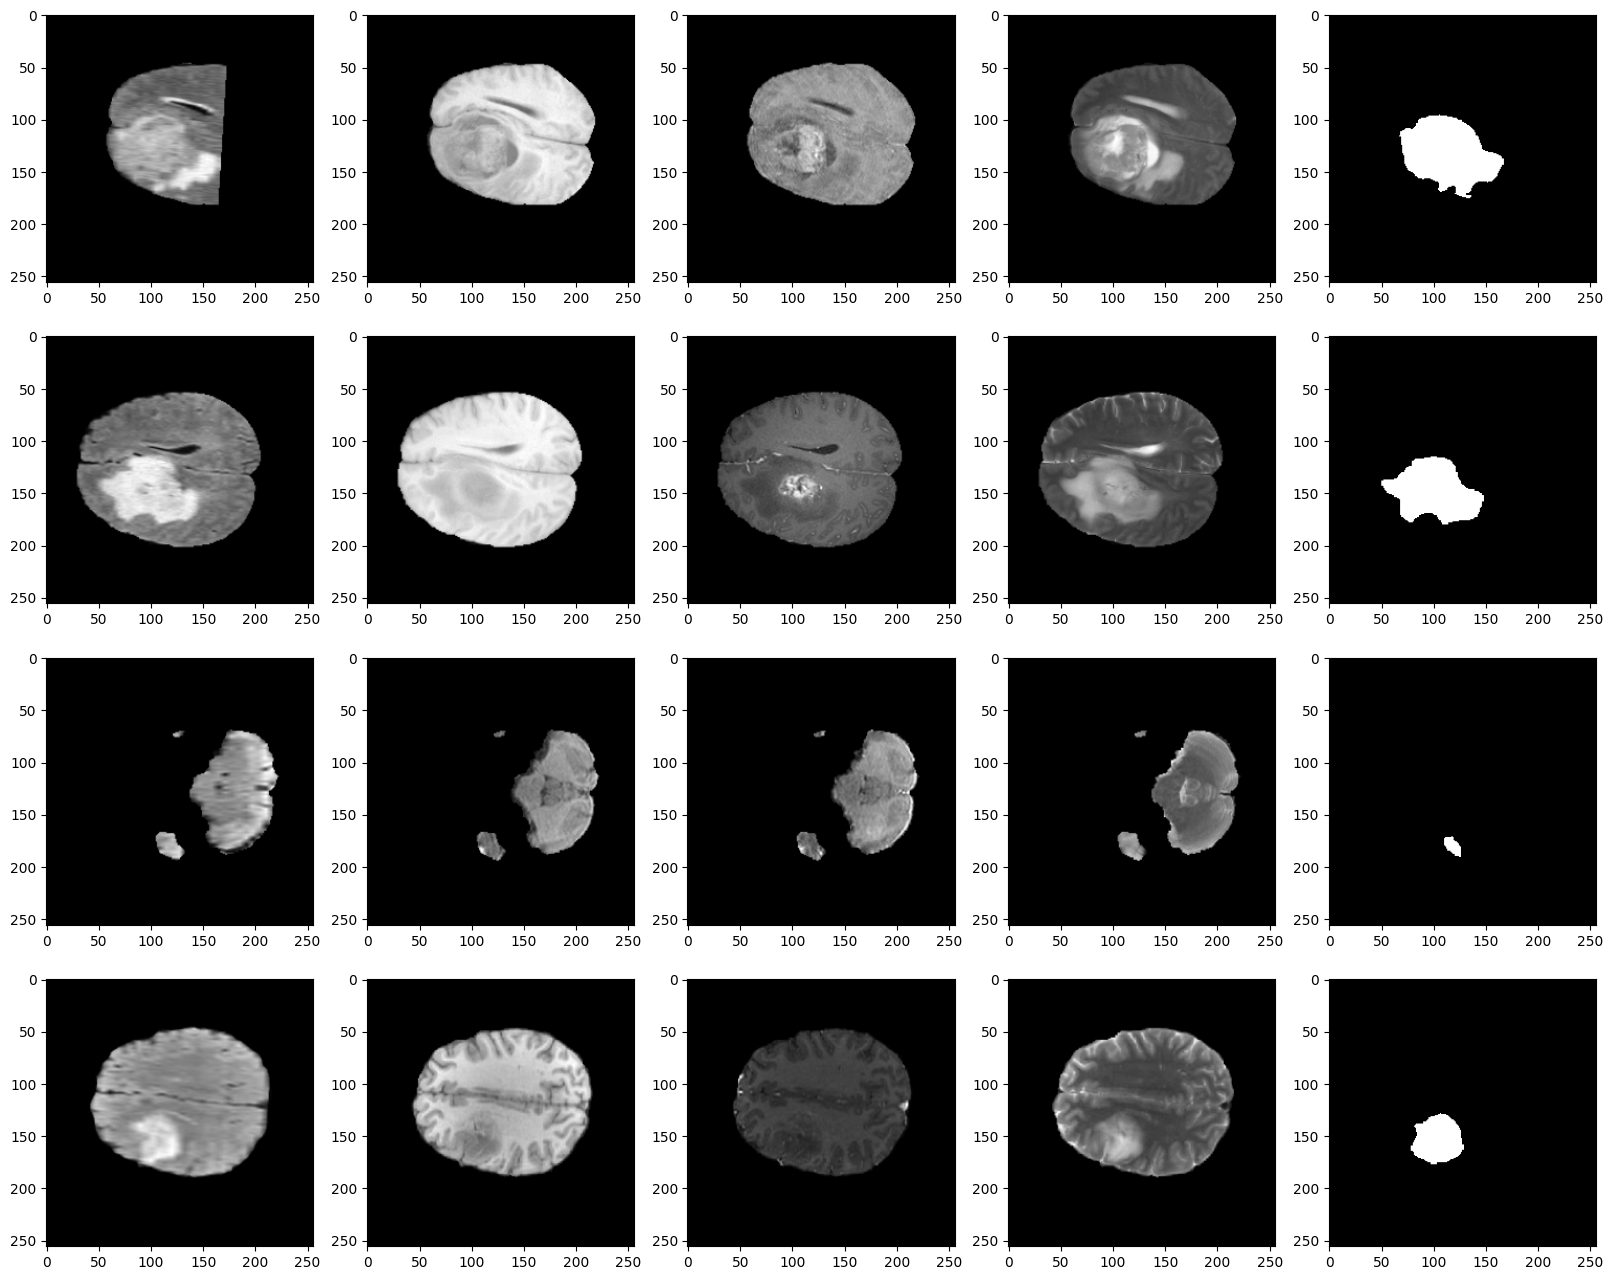

In [4]:
transforms =[['h_flip'], ['v_flip'], ['rotate'], ['crop'], ['elastic_5'], ['brightness'], ['rotate', 'crop', 'elastic_5', 'brightness']]
t_dataset = Brats2013('train', transforms[5])
v_dataset = Brats2013('val')
test_dataset = Brats2013('test')
print(f"Training Size = {len(t_dataset)}, Validation Size = {len(v_dataset)}, Test Size = {len(test_dataset)}")
print(f"Total Size = {sum([len(t_dataset), len(v_dataset), len(test_dataset)])}")
dataloader = DataLoader(dataset=t_dataset, batch_size=4, shuffle=True) # pin_memory=True, num_workers=8

for imgs, masks in dataloader:
    print(imgs.shape, imgs.dtype, imgs.min(), imgs.max())
    print(masks.shape, masks.dtype, masks.min(), masks.max())
    break     

fig, axes = plt.subplots(4,5, figsize=(20,16))
for b_n in range(4):
    for i in range(4):
        axes[b_n][i].imshow(imgs[b_n][i], cmap='gray')
    axes[b_n][4].imshow(masks[b_n], cmap='gray')

In [5]:
# test_img, mask = imgs[2].numpy(), masks[2].numpy()
# print(test_img.shape, test_img[3].min(), test_img[3].max())
# # t_test_img = v2.ElasticTransform(alpha=5.0,sigma=10.0)(imgs[2])
# t_test_img = elasticdeform.deform_random_grid([*test_img, mask], sigma=15, points=3, mode='constant', order=[1]*4+[0])
# # plt.imshow(t_test_img)
# # print(t_test_img.shape, t_test_img.min(), t_test_img.max())
# print(t_test_img[3].min(), t_test_img[3].max())
# print(t_test_img[4].min(), t_test_img[4].max())
# fig, axes = plt.subplots(1,5, figsize=(20,16))
# for i in range(4):
#     axes[i].imshow(t_test_img[i], cmap='gray')
# axes[4].imshow(t_test_img[4], cmap='gray')

# all_datasets = []
# for transform in transforms:
#     all_datasets.append(Brats2013('train', transform=transform))

# augmented_dataset = ConcatDataset([t_dataset, *all_datasets])
# print(len(augmented_dataset))

### Model

In [6]:
class InitWeights_He(object):
    def __init__(self, neg_slope=1e-2):
        self.neg_slope = neg_slope

    def __call__(self, module):
        if isinstance(module, nn.Conv3d) or isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.ConvTranspose3d):
            module.weight = nn.init.kaiming_normal_(
                module.weight, a=self.neg_slope)
            if module.bias is not None:
                module.bias = nn.init.constant_(module.bias, 0)
                
class VGGBlock(torch.nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, dropout_p=0.2):
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out
    
class UNetPP_Xtra(torch.nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        self.weightInitializer = InitWeights_He()

        
        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(
            scale_factor=2, mode='bicubic', align_corners=True)
        
        self.down = nn.functional.interpolate#(scale_factor=2, mode='bicubic')
        self.d_conv0_0_1 = VGGBlock(nb_filter[0], nb_filter[0], nb_filter[0])
        self.d_conv0_0_2 = VGGBlock(nb_filter[0], nb_filter[0], nb_filter[0])
        self.d_conv0_0_3 = VGGBlock(nb_filter[0], nb_filter[0], nb_filter[0])
        self.d_conv0_0_4 = VGGBlock(nb_filter[0], nb_filter[0], nb_filter[0])
        
        self.d_conv1_0_2 = VGGBlock(nb_filter[1], nb_filter[1], nb_filter[1])
        self.d_conv1_0_3 = VGGBlock(nb_filter[1], nb_filter[1], nb_filter[1])
        self.d_conv1_0_4 = VGGBlock(nb_filter[1], nb_filter[1], nb_filter[1])

        self.d_conv2_0_3 = VGGBlock(nb_filter[2], nb_filter[2], nb_filter[2])
        self.d_conv2_0_4 = VGGBlock(nb_filter[2], nb_filter[2], nb_filter[2])
        
        self.d_conv3_0_4 = VGGBlock(nb_filter[3], nb_filter[3], nb_filter[3])
        
        self.intermidiate_cnn = VGGBlock(nb_filter[4] + 32 + 64 + 128 + 256, nb_filter[4], nb_filter[4])
        
        
        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1] + 32, nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2] + 32 + 64, nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3] + 32 + 64 + 128, nb_filter[4], nb_filter[4])
        

        self.conv0_1 = VGGBlock(
            nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(
            nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(
            nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(
            nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(
            nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(
            nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(
            nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(
            nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(
            nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(
            nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            
        self.apply(self.weightInitializer)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        
        x0_0_1 = self.d_conv0_0_1(self.down(x0_0, scale_factor=1/2, mode='bicubic'))
        x0_0_2 = self.d_conv0_0_2(self.down(x0_0, scale_factor=1/4, mode='bicubic'))
        x0_0_3 = self.d_conv0_0_3(self.down(x0_0, scale_factor=1/8, mode='bicubic'))
        x0_0_4 = self.d_conv0_0_4(self.down(x0_0, scale_factor=1/16, mode='bicubic'))
        
        
        x1_0 = self.conv1_0(self.pool(x0_0))
        
        x1_0_2 = self.d_conv1_0_2(self.down(x1_0, scale_factor=1/2, mode='bicubic'))
        x1_0_3 = self.d_conv1_0_3(self.down(x1_0, scale_factor=1/4, mode='bicubic'))
        x1_0_4 = self.d_conv1_0_4(self.down(x1_0, scale_factor=1/8, mode='bicubic'))
        
        
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        # print(x1_0.shape)

        x2_0 = self.conv2_0(self.pool(torch.cat([x1_0, x0_0_1], 1)))
        
        x2_0_3 = self.d_conv2_0_3(self.down(x2_0, scale_factor=1/2, mode='bicubic'))
        x2_0_4 = self.d_conv2_0_4(self.down(x2_0, scale_factor=1/4, mode='bicubic'))

        
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        # print(x2_0.shape)
        
        x3_0 = self.conv3_0(self.pool(torch.cat([x2_0, x0_0_2, x1_0_2], 1)))
        
        x3_0_4 = self.d_conv3_0_4(self.down(x3_0, scale_factor=1/2, mode='bicubic'))
        
        
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        # print(x3_0.shape)
        
        x4_0 = self.conv4_0(self.pool(torch.cat([x3_0, x0_0_3, x1_0_3, x2_0_3], 1)))
        
        # print(x4_0.shape, torch.cat([x4_0, x0_0_4, x1_0_4, x2_0_4, x3_0_4], 1).shape)
        
        x4_0 = self.intermidiate_cnn(torch.cat([x4_0, x0_0_4, x1_0_4, x2_0_4, x3_0_4], 1))
        
        # print(x4_0.shape)
        
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(
            torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        
        
        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [7]:
# !pip install torchsummary 
# from torchsummary import summary
# unet = UNetPP(1, 4)
# # unet = Unet(1)
# summary(unet, input_size=(4, 256, 256))

In [8]:
pseudo_data = torch.randn((2, 4, 256, 256))
# unet = UNetPP_Xtra(1, 4)
unet = UNetPP(1, 4)
# unet = Unet(1)
unet(pseudo_data).shape

torch.Size([2, 1, 256, 256])

### Hyper params

In [9]:
max_epochs = 100
batch_size = 18 # change accordingly
lr = 2e-4
num_workers = 4
pin_memory = True

model_path = os.path.join(train_log_path, 'unetpp.pth')


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNetPP_Xtra(1,4)
# model = UNetPP(1, 4)
# model = Unet(1)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


transforms =[['h_flip'], ['v_flip'], ['rotate'], ['crop'], ['elastic_5'], ['brightness'], ['rotate', 'crop', 'elastic_5', 'brightness']]
train_dataset = Brats2013('train')
all_datasets = []
for transform in transforms:
    all_datasets.append(Brats2013('train', transform=transform))
train_dataset = ConcatDataset([train_dataset, *all_datasets])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)

val_dataset = Brats2013('val')
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)
test_dataset = Brats2013('test')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)


print(len(train_dataset), len(val_dataset), len(test_dataloader))

8544 393 22


### Training Loop

In [10]:
def evaluate(model, dataloader):
    with torch.no_grad():
        batch_loss, batch_scores = [], []
        
        for batch_data in dataloader:
            c_bs = batch_data[0].shape[0]
            
            X, Y = batch_data[0].to(device), batch_data[1].to(device) 
            
            Y_ = model(X)
            Y_, Y = Y_.squeeze(), Y.squeeze()
            loss = loss_fun(Y_, Y)
            batch_loss += [loss.cpu().item()]
            
            Y_copy = sigmoid_helper(Y_.detach().cpu()).numpy()
            Y_copy = (Y_copy>=0.5).reshape(*Y_copy.shape).astype(np.uint8)
            scores = iou_dice(Y_copy, Y.detach().cpu().numpy())
            if type(scores) == float:
                scores = [0.0, 0.0]
            batch_scores += [[scores[0], scores[1]]] 
        
    return sum(batch_loss)/len(batch_loss),  np.array(batch_scores).mean(0)

    

# def error_acc_plot(train_loss, val_loss, train_acc, val_acc):
#     plt.figure(figsize=(15,5))
#     plt.subplot(1,2,1)
#     plt.plot(train_loss)
#     plt.plot(val_loss)
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend(["Train", "Validation"])
#     plt.subplot(1,2,2)
#     plt.plot(train_acc)
#     plt.plot(val_acc)
#     plt.xlabel("Epochs")
#     plt.ylabel("ACC")
#     plt.legend(["Train", "Validation"])
#     plt.show()

# def get_predictions(model, dataloader):
#     preds = torch.tensor([])
#     scores = []
#     with torch.no_grad():
#         for data in dataloader:
#             X, Y = data[0].to(device), data[1]            
#             Y_ = model(X).squeeze().detach().cpu()
#             preds = torch.concat((preds,Y_), dim=0)
#             # preds.append(Y_.detach().cpu.numpy())

#             dice = compute_dice(F.sigmoid(Y_), Y)
#             iou = compute_iou(F.sigmoid(Y_), Y)
            
#             scores.append([iou, dice])
            
#     return preds, np.array(scores).mean(0) 
    
def dice_loss(pred, target):
    p_shape = pred.shape
    mean_val = p_shape[0]*p_shape[1] # bs*class
    
    pred = pred
    
    pred, target = pred.flatten(), target.flatten()
    smooth = 1e-8
    intersection = (pred * target).sum()
    union = (pred+target).sum()
    dice_coefficient = (2*intersection + smooth) /  (union + smooth)
    dice_coefficient = dice_coefficient/mean_val
    dice_loss = 1-dice_coefficient
    return dice_loss


def detect_edges(gray_img):
    gray_img = gray_img
    sobel_x = torch.tensor([[2,2,4,2,2], [1,1,2,1,1], [0,0,0,0,0], [-1,-1,-2,-1,-1], [-2,-2,-4,-2,-2]], dtype=torch.float32).view(1, 1, 5, 5).to(device)
    sobel_y = torch.tensor([[2,1,0,-1,-2], [2,1,0,-1,-2], [4,2,0,-2,-4], [2,1,0,-1,-2], [2,1,0,-1,-2]], dtype=torch.float32).view(1, 1, 5, 5).to(device)
    edge_x = F.conv2d(gray_img, sobel_x, padding=2)
    edge_y = F.conv2d(gray_img, sobel_y, padding=2)
    edge_magnitude = torch.sqrt(edge_x**2 + edge_y**2).squeeze(0)
    return edge_magnitude/edge_magnitude.max()
    
def edge_loss(pred, target):
    pred, target = pred.unsqueeze(1).float(), target.unsqueeze(1).float()
    edge_mask =  detect_edges(target)
    weighted_loss = edge_mask*F.l1_loss(pred, target, reduction='none')
    loss_edge = weighted_loss.mean()
    return loss_edge

softmax_helper = lambda x: F.softmax(x, 1)
sigmoid_helper = lambda x: F.sigmoid(x)
# ce = torch.nn.CrossEntropyLoss()
bce = torch.nn.BCEWithLogitsLoss()

# sigmoid_focal_loss(pred, target, reduction='mean')
# sdl = SoftDiceLoss(apply_nonlin=sigmoid_helper, batch_dice=True, do_bg=True)
sdl = SoftDiceLossSquared(apply_nonlin=softmax_helper, batch_dice=True, do_bg=True)

# def loss_fun(Y_, Y):
#     # dl = sdl(Y_, Y)
#     _, Y = Y.max(1)
#     cl = ce(Y_, Y) 
#     # return cl + dl
#     return cl

def loss_fun(Y_, Y):
    dl = sdl(Y_, Y)
    # _, Y = Y.max(1)
    # cl = ce(Y_, Y) 
    # return cl + dl
    # print(Y.min(), Y.max(), Y_.min(), Y_.max())
    bcl = bce(Y_.float(), Y.float())
    loss_edge = edge_loss(Y_, Y)
    return bcl + 0.7 * dl + 0.7 * loss_edge

# def loss_fun(Y_, Y):
#     # dl = sdl(Y_, Y)
#     sfl = sigmoid_focal_loss(Y_.float(), Y.float(), reduction='mean')
#     return sfl #+ 0.7 * dl

Epoch 1: => t_loss=-0.4585, t_iou=0.8017, t_dice=0.8862, v_loss=-0.5437, v_iou=0.6376, v_dice=0.7759


Epoch 2: => t_loss=-0.5188, t_iou=0.8505, t_dice=0.9188, v_loss=-0.5553, v_iou=0.5833, v_dice=0.7328


Epoch 3: => t_loss=-0.5257, t_iou=0.8586, t_dice=0.9234, v_loss=-0.5671, v_iou=0.6265, v_dice=0.7673


Epoch 4: => t_loss=-0.5343, t_iou=0.8664, t_dice=0.9281, v_loss=-0.5710, v_iou=0.6306, v_dice=0.7706


Epoch 5: => t_loss=-0.5349, t_iou=0.8677, t_dice=0.9288, v_loss=-0.5739, v_iou=0.6461, v_dice=0.7825


Epoch 6: => t_loss=-0.5420, t_iou=0.8795, t_dice=0.9357, v_loss=-0.5733, v_iou=0.6307, v_dice=0.7707


Epoch 7: => t_loss=-0.5445, t_iou=0.8815, t_dice=0.9368, v_loss=-0.5759, v_iou=0.6606, v_dice=0.7929


Epoch 8: => t_loss=-0.5421, t_iou=0.8673, t_dice=0.9285, v_loss=-0.5752, v_iou=0.6550, v_dice=0.7890


Epoch 9: => t_loss=-0.5438, t_iou=0.8832, t_dice=0.9378, v_loss=-0.5686, v_iou=0.6367, v_dice=0.7750


Epoch 10: => t_loss=-0.5431, t_iou=0.8897, t_dice=0.9415, v_loss=-0.5717, v_iou=0.6568, v_dice=0.7900


Epoch 11: => t_loss=-0.5462, t_iou=0.8897, t_dice=0.9415, v_loss=-0.5769, v_iou=0.6847, v_dice=0.8107


Epoch 12: => t_loss=-0.5492, t_iou=0.8917, t_dice=0.9426, v_loss=-0.5773, v_iou=0.6844, v_dice=0.8109


Epoch 13: => t_loss=-0.5497, t_iou=0.8952, t_dice=0.9446, v_loss=-0.5768, v_iou=0.6804, v_dice=0.8077


Epoch 14: => t_loss=-0.5499, t_iou=0.8916, t_dice=0.9426, v_loss=-0.5729, v_iou=0.6496, v_dice=0.7849


Epoch 15: => t_loss=-0.5521, t_iou=0.8968, t_dice=0.9455, v_loss=-0.5689, v_iou=0.6687, v_dice=0.7994


Epoch 16: => t_loss=-0.5532, t_iou=0.8992, t_dice=0.9469, v_loss=-0.5773, v_iou=0.6989, v_dice=0.8214


Epoch 17: => t_loss=-0.5505, t_iou=0.8995, t_dice=0.9470, v_loss=-0.5776, v_iou=0.7018, v_dice=0.8234


Epoch 18: => t_loss=-0.5512, t_iou=0.8986, t_dice=0.9465, v_loss=-0.5660, v_iou=0.6565, v_dice=0.7902


Epoch 19: => t_loss=-0.5504, t_iou=0.9023, t_dice=0.9486, v_loss=-0.5752, v_iou=0.6963, v_dice=0.8189


Epoch 20: => t_loss=-0.5573, t_iou=0.9035, t_dice=0.9492, v_loss=-0.5765, v_iou=0.7016, v_dice=0.8235


Epoch 21: => t_loss=-0.5567, t_iou=0.9032, t_dice=0.9490, v_loss=-0.5476, v_iou=0.6599, v_dice=0.7930


Epoch 22: => t_loss=-0.5523, t_iou=0.9054, t_dice=0.9503, v_loss=-0.5676, v_iou=0.6726, v_dice=0.8024


Epoch 23: => t_loss=-0.5534, t_iou=0.9047, t_dice=0.9499, v_loss=-0.5715, v_iou=0.6740, v_dice=0.8031


Epoch 24: => t_loss=-0.5561, t_iou=0.9021, t_dice=0.9484, v_loss=-0.5668, v_iou=0.6390, v_dice=0.7769


Epoch 25: => t_loss=-0.5559, t_iou=0.9047, t_dice=0.9499, v_loss=-0.5711, v_iou=0.6889, v_dice=0.8138
Early Stopping


Text(0, 0.5, 'Loss')

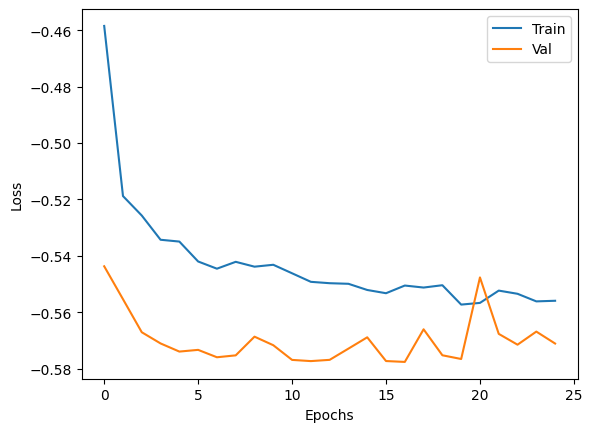

In [11]:
# pbar = tqdm(range(max_epochs), desc='Epoch')
# for epoch in pbar:

train_loss, train_scores = [], []
val_loss, val_scores = [], []
prev_l, pat, j = 99, 7, 0 # 999
for epoch in range(max_epochs):
    # train

    batch_loss, batch_acc = [], []
    batch_scores = []


    pbar_batch = tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False)
    for data in pbar_batch:
    # for data in tqdm(train_dataloader):
        c_bs = data[0].shape[0]
        
        X, Y = data[0].to(device), data[1].to(device) 
        
        optimizer.zero_grad()
        Y_ = model(X)
        Y_, Y = Y_.squeeze(), Y.squeeze()
        loss = loss_fun(Y_, Y)   
        loss.backward()
        optimizer.step()
        
        batch_loss += [loss.cpu().item()]
        # iou, dice
        # scores = iou_dice(Y_.detach().cpu().numpy(), Ycopy.detach().cpu().numpy())
        Y_copy = sigmoid_helper(Y_.detach().cpu()).numpy()
        Y_copy = (Y_copy>=0.5).reshape(*Y_copy.shape).astype(np.uint8)
        scores = iou_dice(Y_copy, Y.detach().cpu().numpy())
        if type(scores) == float:
            scores = [0.0, 0.0]
        batch_scores += [[scores[0], scores[1]]] 
         
        pbar_batch.set_postfix({'b_loss':batch_loss[-1], 'iou':batch_scores[-1][0], 'dice':batch_scores[-1][1]})
    
    train_loss.append(sum(batch_loss)/len(batch_loss))
    # print(batch_scores)
    batch_scores = np.array(batch_scores).mean(0)
    train_scores.append([batch_scores[0], batch_scores[1]])

    # checking
    b_n = random.randint(0, min(batch_size, c_bs)-1)
    mix_img = X[b_n].detach().cpu() * 255
    mix_img = np.concatenate((mix_img[0], mix_img[1], mix_img[2], mix_img[3],Y[b_n].detach().cpu()*255, Y_[b_n].detach().cpu()*255), axis=1)
    cv2.imwrite(os.path.join(train_log_path, f'img_{epoch+1}.png'), mix_img)

    
        
    # val
    model.eval()
    l, s = evaluate(model, val_dataloader)
    val_loss.append(l)
    val_scores.append(s)
    print(f"Epoch {epoch+1}: => t_loss={train_loss[-1]:2.4f}, t_iou={train_scores[-1][0]:2.4f}, t_dice={train_scores[-1][1]:2.4f}, v_loss={val_loss[-1]:2.4f}, v_iou={val_scores[-1][0]:2.4f}, v_dice={val_scores[-1][1]:2.4f}")
    
    if l < prev_l:
        prev_l = l
        torch.save(model, model_path)
        j=0

    # if s[1] > prev_l:
    #     prev_l = s[1]
    #     torch.save(model, model_path)
    #     j=0
    else:
        j += 1
        if j > pat:
            print("Early Stopping")
            break
    
    model.train()

    
train_losses, val_losses = np.array(train_loss), np.array(val_loss)
# saving losses
with open(f'{train_log_path}/losses.pkl', 'wb') as f:
    pickle.dump({'train_losses':train_losses, 'val_losses':val_losses}, f)

# error_acc_plot(train_loss, val_loss, train_acc, val_acc)
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train', 'Val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Test dataset


In [12]:
pretrained_path =  model_path
model = torch.load(pretrained_path)
model.eval()
test_loss, scores = evaluate(model, val_dataloader)
test_loss, scores

/tmp/ipykernel_23/1742200965.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(pretrained_path)


(-0.5775721858848225, array([0.70183103, 0.82342576]))

In [13]:
pretrained_path =  model_path
model = torch.load(pretrained_path)
model.eval()
test_loss, scores = evaluate(model, test_dataloader)
test_loss, scores

/tmp/ipykernel_23/1535728652.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(pretrained_path)


(-0.6121067702770233, array([0.8433545 , 0.91488837]))

### Model loading

In [14]:
# pretrained_path =  '/kaggle/input/unetpp-sqloss/unetpp.pth'
# model = torch.load(pretrained_path)
# model.eval()

# preds, scores = evaluate(model, test_dataloader)
# scores